# Estimator Benchmarks

Notebook for benchmarking known IV estimators against different data generating processes.

Current roster:
- Split-sample IV **TODO**
- 2SLS
- Jackknife IV **TODO**
- LIML 
- Mostly harmless ML **TODO**
- DeepIV **TODO**
- DoubleML **TODO**

# Imports

In [19]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from linearmodels.iv import IV2SLS

In [8]:
# import pre-condition: run `pip install -e .` in the root directory
from src.data.lin_norm_generator import LinearNormalDataGenerator
from src.viz.plotting import kde_ridgeplot

df = LinearNormalDataGenerator().generate()

# TabPFN-style data generating process

In [9]:
import torch
from torch import nn
from torch.distributions import MultivariateNormal
import torch.nn.functional as F

In [10]:
MAX_VARS = 100

class GaussianNoise(nn.Module):
    """
    Lifted from https://github.com/automl/TabPFN/blob/main/tabpfn/priors/mlp.py
    TODO introduce shared covariance matrix
    """
    def __init__(self, std, device):
        super().__init__()
        self.std = std
        self.device=device

    def forward(self, x):
        return x + torch.normal(torch.zeros_like(x), self.std)


def causes_sampler_f(num_causes):
    means = np.random.normal(0, 1, (num_causes))
    std = np.abs(np.random.normal(0, 1, (num_causes)) * means)
    return means, std

class IVGenerator(nn.Module):
    """
    Neural network to generate IV datasets.

    TODO add ability to generate IV controls to cover the Angrist/Frandsen case
    """
    def __init__(self, 
                tau: float,
                max_vars: int,
                n_instruments: int,
                instrument_covariance: torch.Tensor,
                instrument_strength: float, # this currently translates to mu^2/n_samples
                tau_activation: str = 'identity',
                instrument_activation: str = 'identity',
                # TODO add controls as well
                control_activation: str = 'identity',
                control_covariance: torch.Tensor = None, 
                control_str: float = 0,
                n_controls: int = 0,

                ):
        super().__init__()
        self.max_vars = max_vars
        # TODO are these actually needed?
        #self.controls = nn.Linear(max_vars, 1)
        self.instruments = nn.Linear(max_vars, 1)

        #Nself.n_controls = n_controls
        self.n_instruments = n_instruments

        if control_covariance is not None:
            assert control_covariance.shape == (n_controls, n_controls)

        assert instrument_covariance.shape == (n_instruments, n_instruments)
        self.instrument_covariance = instrument_covariance
        self.instrument_sampler = MultivariateNormal(torch.zeros(self.n_instruments), self.instrument_covariance)
        
        # currently follows the Beta pattern of Lennon et al. 2022, corresponds to their pi
        self.instrument_coefficients = torch.pow(torch.ones(self.n_instruments) * 0.5, 
                                         torch.arange(0, self.n_instruments))

        # shuffle coefficients
        self.instrument_coefficients = self.instrument_coefficients[torch.randperm(self.n_instruments)]
        # determine C coefficient
        A = torch.t(self.instrument_coefficients) @ self.instrument_covariance @ self.instrument_coefficients
        C = torch.sqrt(instrument_strength / (instrument_strength*A + A))
        print(f"C: {C}")
        self.instrument_coefficients = C * self.instrument_coefficients
        self.sigma_v = torch.sqrt(1 - (torch.t(self.instrument_coefficients) @ self.instrument_covariance @ self.instrument_coefficients))
        print(self.sigma_v)
        self.sigma_y = 1


        
        # TODO need to ensure that confounder covariance is positive definite
        self.confound_covariance = torch.Tensor([[self.sigma_y**2, self.sigma_y*self.sigma_v], 
                                                 [self.sigma_y*self.sigma_v, self.sigma_v**2]])
        print(self.confound_covariance)
        self.confound_sampler = MultivariateNormal(torch.zeros(2), self.confound_covariance)

        self.tau = tau
        self.control_str = control_str

        self.activations = {
            'identity': lambda x: x,
            'relu': F.relu,
            'sigmoid': F.sigmoid,
            'tanh': F.tanh,
            'softplus': F.softplus,
            'leaky_relu': F.leaky_relu,
            'elu': F.elu,
        }
    
        self.tau_activation = self.activations[tau_activation]
        self.instrument_activation = self.activations[instrument_activation]
        #self.confounder_activation = self.activations[confounder_activation]


    def forward(self):
        """Generates a single data sample"""
        #confound_sample = torch.cat([torch.randn(self.n_confounds), torch.zeros(MAX_VARS - self.n_confounds)])

        # noise sample [\epislon_y, \epeilson_v] according to confounder covariance
        #noise_sample = torch.normal(TODO)
        instrument_sample = torch.cat([self.instrument_sampler.sample(), torch.zeros(self.max_vars - self.n_instruments)])

        epislon_y, epsilon_v = self.confound_sampler.sample()
        #confounds = self.confounder_activation(self.confounders(confound_sample))
        pi = torch.cat([self.instrument_coefficients, torch.zeros(self.max_vars - self.n_instruments)])
        treat = self.instrument_activation(torch.t(pi) @ instrument_sample) + epsilon_v
        
        #print(treat.shape)

        outcome = self.tau*self.tau_activation(treat) + torch.randn(1) + epislon_y

        # return data matrix of T, Y, Z
        return torch.cat([torch.Tensor([treat, outcome]), instrument_sample])

        # return data matrix of T, Y, X, Z
        #return torch.cat([treat, outcome, confound_sample, instrument_sample])
        
    def batch(self, batch_size: int):
        """Generate batch of examples"""
        return torch.stack([self.forward() for _ in range(batch_size)])


In [11]:
def generate_cov_matrix(n_vars, base=0.5):
    """Generates the covariance matrix for the instruments per Lennon et al. 2022"""
    cov = np.zeros((n_vars, n_vars))
    for i in range(n_vars):
        for j in range(n_vars):
            cov[i, j] = base**(np.abs(i-j))
    return cov

In [12]:
generate_cov_matrix(3)

array([[1.  , 0.5 , 0.25],
       [0.5 , 1.  , 0.5 ],
       [0.25, 0.5 , 1.  ]])

In [13]:
n_samples = 1000
mu2 = 200
n_instruments = 100
iv_gen = IVGenerator(
            tau=1,
            max_vars=n_instruments,
            n_instruments=n_instruments,
            instrument_covariance=torch.Tensor(generate_cov_matrix(n_instruments)), 
            instrument_strength=mu2/n_samples,
        )

data = iv_gen.batch(n_samples).detach().numpy()

C: 0.3443148136138916
tensor(0.9129)
tensor([[1.0000, 0.9129],
        [0.9129, 0.8333]])


In [14]:
data.shape

(1000, 102)

# Lennon et al. 2022 Replication

In [15]:
data[:, :-2].shape

(1000, 100)

<Axes: >

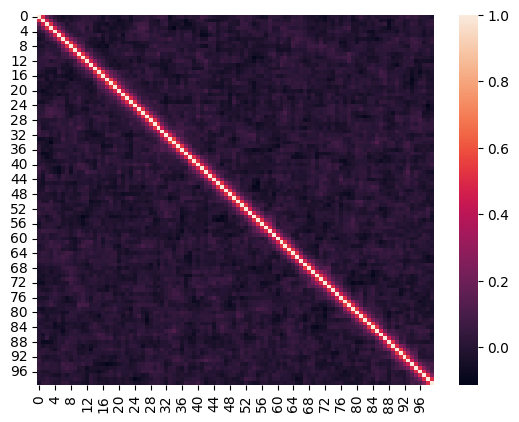

In [16]:
sns.heatmap(np.corrcoef(data[:, 2:].T))

## Run simulations for Lennon et al. 2022 replication

In [17]:
from linearmodels.iv.model import IV2SLS, _OLS, IVLIML
from tqdm import tqdm

In [33]:
from src.model import PoolingMLP
MODEL_CHKPT = "/home/tliu/learning-ivs/workdir/pool_mlp_lennon_bs256_lr0.004_eps100_hidden256_depth4/ckpts/exp_name=pool_mlp_lennon_bs256_lr0.004_eps100_hidden256_depth4-val_loss=0.0070.ckpt"
model = PoolingMLP.load_from_checkpoint(MODEL_CHKPT)
model.eval()

/home/tliu/learning-ivs/src/model/pooling_mlp.py:109: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(m.weight)


PoolingMLP(
  (mine): MINE(
    (fc1): Linear(in_features=3, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=1, bias=True)
    (act): ELU(alpha=1.0)
  )
  (model): Sequential(
    (0): PrePoolingBlock(
      (fc_in): Linear(in_features=102, out_features=256, bias=True)
      (resblock): ResLinearBlock(
        (linear): Sequential(
          (0): LinearBlock(
            (linear): Linear(in_features=256, out_features=256, bias=True)
            (activation): ELU(alpha=1.0)
            (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): LinearBlock(
            (linear): Linear(in_features=256, out_features=256, bias=True)
            (activation): ELU(alpha=1.0)
            (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
       

In [34]:
n_trials = 500


result_dict = {
    'tsls': [],
    'ols': [],
    'liml': [],
    'pool_mlp': [],
}

data_dir = "/home/tliu/learning-ivs/tmp_lennon100_tau1/test"
preds = []
for file_name in tqdm(glob(f"{data_dir}/*.parquet")):
    df = pd.read_parquet(file_name)
    # print(df.shape)
    # print(df.loc[:, df.columns.str.contains('Z')].shape)
    # print(df.T.shape)
# for _ in tqdm(range(n_trials)):
#     data = iv_gen.batch(n_samples).detach().numpy()

#     df = pd.DataFrame(data[:, 2:], columns=[f'z{i}' for i in range(n_instruments)])
#     df['t'] = data[:, 0]
#     df['y'] = data[:, 1]
    
    # TSLS
    iv = IV2SLS(dependent=df['Y'], 
                exog=None,
                endog=df['T'], 
                instruments=df.loc[:, df.columns.str.contains('Z')])
    result_dict['tsls'].append(iv.fit().params['T'])

    # OLS
    ols = _OLS(dependent=df['Y'], exog=df['T'])
    result_dict['ols'].append(ols.fit().params['T'])

    # LIML
    liml = IVLIML(dependent=df['Y'],
                  exog=None,
                  endog=df['T'],
                  instruments=df.loc[:, df.columns.str.contains('Z')])
    result_dict['liml'].append(liml.fit().params['T'])

    # Mostly Harmless ML


    # pooled MLP
    data = torch.tensor(df.to_numpy(), dtype=torch.float32)
    #print(data.shape)
    # create a batch dimension
    data = data.unsqueeze(0)
    result_dict['pool_mlp'].append(model(data).squeeze().item())


result_df = pd.DataFrame(result_dict)

100%|██████████| 1000/1000 [03:53<00:00,  4.28it/s]


In [35]:
result_df.describe()

,tsls,ols,liml,pool_mlp
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.315358,1.613843,0.983970,1.005923
std,0.076712,0.031820,0.162669,0.064873
min,1.025134,1.514039,0.122825,0.806441
25%,1.265097,1.592724,0.890143,0.963467
50%,1.313937,1.613523,1.000373,1.007385
75%,1.365238,1.636548,1.094827,1.048991
max,1.566580,1.713686,1.408199,1.248558


In [36]:
# ridge plots require dataframes in long format
result_df_long = result_df.melt(var_name='method', value_name='estimate')
result_df_long.head()
result_df_long = result_df_long.sort_values('method', ascending=False)

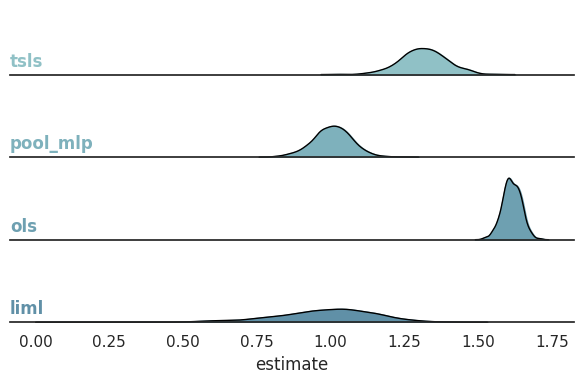

In [41]:
# Initialize the FacetGrid object
#plt.axvline(x=1, ls='--', color='black')
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
kde_ridgeplot(result_df_long, 'method', 'estimate', pal, figsize=(6, 4))
#plt.xlim(0.5, 2)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet("/home/tliu/learning-ivs/tmp_lennon100/train/uid=0-treatment_effect=-1.1086778243435313-n_samples=1000.parquet")

In [ ]:
df.dtypes

T      float32
Y      float32
Z0     float32
Z1     float32
Z2     float32
        ...   
Z95    float32
Z96    float32
Z97    float32
Z98    float32
Z99    float32
Length: 102, dtype: object